In [10]:
# Calculations of accretion rates for Bondi-Hoyle-Lyttleton (BHL) 
# accretion model used in reference paper M. Ricotti et al. 
# https://arxiv.org/abs/0709.0524 and Park Ricotti Model (PR)
# accretion model as per F. Scarcella et al. 2020, 
# https://arxiv.org/abs/2012.10421 . 

# Here, the value of the speed of sound in the ioinized region of 
# PR Model is chosen as c_s,in = 25 c_s. c_s,in is the free parameter 
# of PR accretion Model.


# The values of v_pbh, c_s and v_eff are used as per 
# Vivian Poulin & Pasquale D. Serpico et al. 2007 
# https://arxiv.org/abs/1707.04206. 


# In this notebook, we consider PBHs with and without DM halos of density profile of 
# ρ(r) ∝ r^{-3/2} as per B.J. Kavanagh et al. https://arxiv.org/pdf/1805.09034.pdf


from scipy.integrate import quad
import numpy as np
from scipy.integrate import odeint
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy.integrate as spi
from scipy.integrate import solve_ivp
from scipy import integrate
import matplotlib.ticker
from scipy.optimize import bisect, brentq, newton, root, toms748
from PRaccretion import*
import math
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})


def c_s(z):
    return c_s_Serpico(z)

def v_pbh(z):
    return v_L_Serpico(z)

def v_eff(z):
    return v_eff_Serpico(z)

def x_e(z):
    if z < z_rec:
        return e_fraction
    else:
        return 1

    
    
    
# BHL accretion Model around isolated PBHs 
def r_B_pbh(z, m):
    return (G * m)/(v_eff(z)**2)

def β_cap_pbh(z, m): # Here, β_pbh = β(m_pbh)
    return 1e-4 * m * (((1+z)/1000)**(3/2)) * (((5.74e3 * (yr/pc))/v_eff(z))**3) * (0.257 + 1.45 * (x_e(z)/0.01) * (((1+z)/1000)**(5/2)))

def λ_pbh(z, m):
    def x_cr(z, m):
        return (-1 + np.sqrt(1 + β_cap_pbh(z, m)))/β_cap_pbh(z, m) 
    return np.exp((9/2)/(3 + β_cap_pbh(z, m)**(0.75))) * (x_cr(z, m)**2)

def M_dot_pbh_BHL(z, m):
    return 4 * np.pi * λ_pbh(z, m) *  ρ(z) * v_eff(z) * (r_B_pbh(z, m)**2)

def m_dot_pbh_BHL(z, m):
    return M_dot_pbh_BHL(z, m)/M_dot_Edd(z, m) 

def M_dot_pbh_BHL_by_dz(z, m):
    return M_dot_pbh_BHL(z, m) * (dt_dz(z))




# BHL accretion Model in the presence of DM halos around isolated PBHs  
def r_ta(z, m):
    if DM_profile94 == True:
        return r_ta_Jangra(z, m)
    else:
        return r_ta_Kavanagh(z, m)

def M_halo(z, m): # Mass of the DM halo at turn around radius r_ta.
    if DM_profile94 == True:
        return M_halo_Jangra(z, m)
    else:
        return M_halo_Kavanagh(z, m)


def r_B_total(z, m):
    return (G * (m+ M_halo(z, m)))/(v_eff(z)**2)
    
    
def r_B_halo(z, m):
    return (G * M_halo(z, m))/(v_eff(z)**2)


def r_B_eff(z, m):
    if r_ta(z, m) < r_B_halo(z, m):
        r_B_eff_var =  (r_B_halo(z, m) + r_B_pbh(z, m))
    else:
        def a(z, m):
             return  (r_B_halo(z, m)/(1-p)) * (1/(r_ta(z, m)**p))
        def b(z, m):
            return 1  +   (p/(1-p)) * (r_B_halo(z, m)/r_ta(z, m))
        def c(z, m):
            return   r_B_pbh(z, m)
        x_upper_limit =  r_B_pbh(z, m) + r_B_halo(z, m) # Here, x = r_B,eff
        x_lower_limit = r_B_pbh(z, m)
        roots = newton(lambda x: (a(z, m) * (x**p)) - b(z, m)*x + c(z, m),  x_upper_limit)
        r_B_eff_var = roots
        #print(r_B_eff_var )
    return r_B_eff_var    
        

def β_cap_halo(z, m): # Here, β_halo = β(m_pbh + m_halo)
    return 1e-4 * (m + M_halo(z, m)) * (((1+z)/1000)**(3/2)) * (((5.74e3 * (yr/pc))/v_eff(z))**3) * (0.257 + 1.45 * (x_e(z)/0.01) * (((1+z)/1000)**(5/2)))

def λ_halo(z, m):
    def x_cr(z, m):
        return (-1 + np.sqrt(1 + β_cap_halo(z, m)))/β_cap_halo(z, m) 
    return np.exp((9/2)/(3 + β_cap_halo(z, m)**(0.75))) * (x_cr(z, m)**2)


def M_dot_halo_BHL(z, m):
    #print("r_B_eff =", r_B_eff(z, m))
    return 4 * np.pi * λ_halo(z, m) * ρ(z) * v_eff(z) * (r_B_eff(z, m)**(2))

def m_dot_halo_BHL(z, m):
    return M_dot_halo_BHL(z, m)/M_dot_Edd(z, m) 

def M_dot_halo_BHL_by_dz(z, m):
    return M_dot_halo_BHL(z, m) * (dt_dz(z))







In [11]:
# Calculations of the accretion parameters and accretion rate 
# as per the DM density profile of ρ(r) ∝ r^{-9/4}.

DM_profile94 = False
alpha = 3/2

p = 3 - alpha

In [3]:
# Calculations for PBHs with and without DM halos as per
# BHL Model

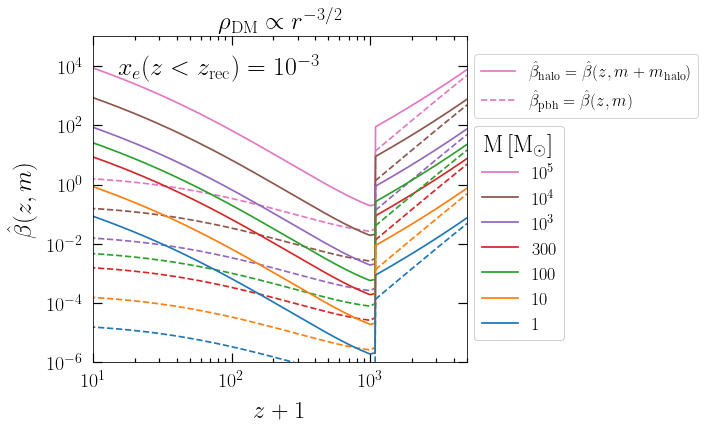

In [3]:
# Plots of β-parameter with and without the presence of
# DM halos with the fact that β_pbh = β(m_pbh) and
# β_halo = β(m_pbh + m_halo)

# Here, the electron fraction of the accreted gas after recombination is 
# considered as x_e = 1e-3.



colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


mi_arr = np.array([1e5, 1e4, 1e3, 1e2, 300, 10, 1])
z_array = np.geomspace(1, 1e4, 1000)
β_pbh_array = np.zeros(len(z_array))
β_halo_array = np.zeros(len(z_array))

e_fraction = 1e-3


for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        β_pbh_array[i] = β_cap_pbh(z, m)
        β_halo_array[i] = β_cap_halo(z, m)
    ax.loglog(z_array, β_halo_array, color = color)
    ax.loglog(z_array, β_pbh_array, color = color, ls = '--')

    

plt.text(15, 5000, '$x_{e}(z < z_\mathrm{rec}) = 10^{-3}$', fontsize = 26)
plt.xlabel('$z+1$',  fontsize = 24.5, labelpad = 10)
plt.ylabel(r'$\hat \beta(z, m)$', fontsize = 25, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [r"$\hat \beta_\mathrm{halo} = \hat \beta(z, m + m_\mathrm{halo})$", r"$\hat \beta_\mathrm{pbh} = \hat \beta(z, m)$"],
        title_fontsize = 20, loc = (1.02, 0.75), prop = {"size":17})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 24, loc = (1.02, 0.07), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)

plt.xlim(10, 5000)
plt.ylim(1e-6, 1e5)
plt.title(r'$\rho_\mathrm{DM} \propto r^{-3/2}$', fontsize = 25, pad = 8)
plt.savefig('βvsz_xe1e-3_halo.pdf', bbox_inches = 'tight')
plt.show()

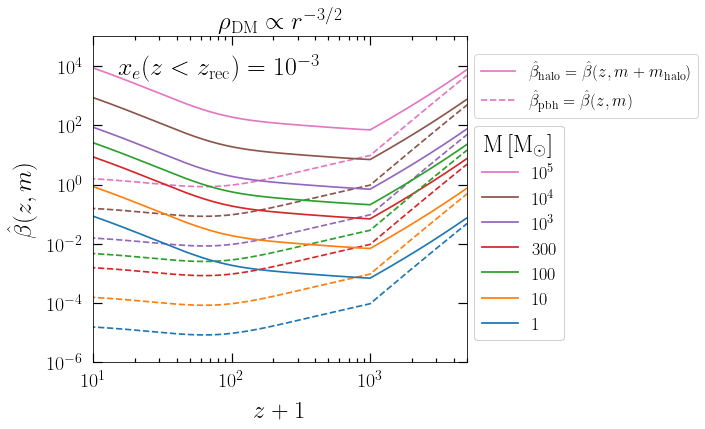

In [4]:
# Plots of β-parameter with and without the presence of
# DM halos with the fact that β_pbh = β(m_pbh) and
# β_halo = β(m_pbh + m_halo)

# Here, the electron fraction of the accreted gas after recombination is 
# considered as x_e = 1.


colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


mi_arr = np.array([1e5, 1e4, 1e3, 1e2, 300, 10, 1])
z_array = np.geomspace(1, 1e4, 1000)
β_pbh_array = np.zeros(len(z_array))
β_halo_array = np.zeros(len(z_array))

e_fraction = 1


for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        β_pbh_array[i] = β_cap_pbh(z, m)
        β_halo_array[i] = β_cap_halo(z, m)
    ax.loglog(z_array, β_halo_array, color = color)
    ax.loglog(z_array, β_pbh_array, color = color, ls = '--')

    

plt.text(15, 5000, '$x_{e}(z < z_\mathrm{rec}) = 10^{-3}$', fontsize = 26)
plt.xlabel('$z+1$',  fontsize = 24.5, labelpad = 10)
plt.ylabel(r'$\hat \beta(z, m)$', fontsize = 25, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [r"$\hat \beta_\mathrm{halo} = \hat \beta(z, m + m_\mathrm{halo})$", r"$\hat \beta_\mathrm{pbh} = \hat \beta(z, m)$"],
        title_fontsize = 20, loc = (1.02, 0.75), prop = {"size":17})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 24, loc = (1.02, 0.07), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)

plt.xlim(10, 5000)
plt.ylim(1e-6, 1e5)
plt.title(r'$\rho_\mathrm{DM} \propto r^{-3/2}$', fontsize = 25, pad = 8)
plt.savefig('βvsz_xe1_halo.pdf', bbox_inches = 'tight')
plt.show()

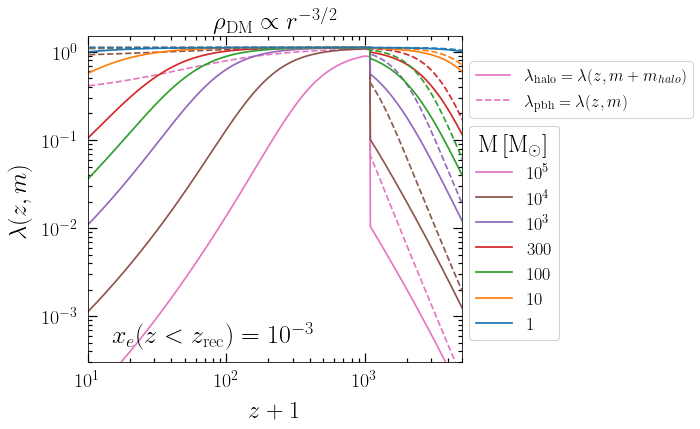

In [5]:
# Plots of β-parameter with and without the presence of
# DM halos with the fact that λ_pbh = λ(m_pbh) and
# λ_halo = λ(m_pbh + m_halo)

# Here, the electron fraction of the accreted gas after recombination is 
# considered as x_e = 1e-3.



colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


mi_arr = np.array([1e5, 1e4, 1e3, 1e2, 300, 10, 1])
z_array = np.geomspace(1, 1e4, 1000)
λ_pbh_array = np.zeros(len(z_array))
λ_halo_array = np.zeros(len(z_array))


e_fraction = 1e-3


for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        λ_pbh_array[i] = λ_pbh(z, m)
        λ_halo_array[i] = λ_halo(z, m)
    ax.loglog(z_array, λ_halo_array, color = color)
    ax.loglog(z_array, λ_pbh_array, color = color, ls = '--')
    

    
plt.xlim(10, 5000)
plt.ylim(3e-4, 1.5)
plt.text(15, 5e-4, '$x_{e}(z < z_\mathrm{rec}) = 10^{-3}$', fontsize = 26)
plt.xlabel('$z+1$',  fontsize = 24.5, labelpad = 10)
plt.ylabel(r'$ \lambda(z, m)$', fontsize = 25, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [r"$\lambda_\mathrm{halo} = \lambda(z, m + m_{halo})$", r"$\lambda_\mathrm{pbh} = \lambda(z, m)$"],
        title_fontsize = 20, loc = (1.02, 0.75), prop = {"size":17})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 24, loc = (1.02, 0.07), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)


plt.title(r'$\rho_\mathrm{DM} \propto r^{-3/2}$', fontsize = 25, pad = 8)
plt.savefig('λvsz_xe1e-3_halo.pdf', bbox_inches = 'tight')
plt.show()

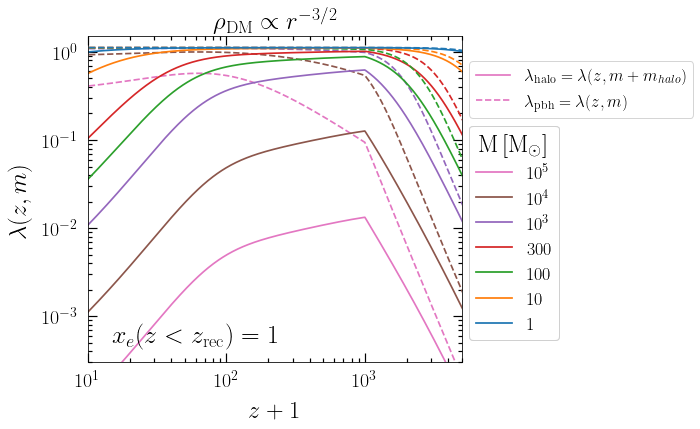

In [6]:
# Plots of β-parameter with and without the presence of
# DM halos with the fact that λ_pbh = λ(m_pbh) and
# λ_halo = λ(m_pbh + m_halo)

# Here, the electron fraction of the accreted gas after recombination is 
# considered as x_e = 1e-3.



colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


mi_arr = np.array([1e5, 1e4, 1e3, 1e2, 300, 10, 1])
z_array = np.geomspace(1, 1e4, 1000)
λ_pbh_array = np.zeros(len(z_array))
λ_halo_array = np.zeros(len(z_array))


e_fraction = 1


for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        λ_pbh_array[i] = λ_pbh(z, m)
        λ_halo_array[i] = λ_halo(z, m)
    ax.loglog(z_array, λ_halo_array, color = color)
    ax.loglog(z_array, λ_pbh_array, color = color, ls = '--')
    

    
plt.xlim(10, 5000)
plt.ylim(3e-4, 1.5)
plt.text(15, 5e-4, '$x_{e}(z < z_\mathrm{rec}) = 1$', fontsize = 26)
plt.xlabel('$z+1$',  fontsize = 24.5, labelpad = 10)
plt.ylabel(r'$ \lambda(z, m)$', fontsize = 25, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [r"$\lambda_\mathrm{halo} = \lambda(z, m + m_{halo})$", r"$\lambda_\mathrm{pbh} = \lambda(z, m)$"],
        title_fontsize = 20, loc = (1.02, 0.75), prop = {"size":17})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 24, loc = (1.02, 0.07), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)


plt.title(r'$\rho_\mathrm{DM} \propto r^{-3/2}$', fontsize = 25, pad = 8)
plt.savefig('λvsz_xe1_halo.pdf', bbox_inches = 'tight')
plt.show()

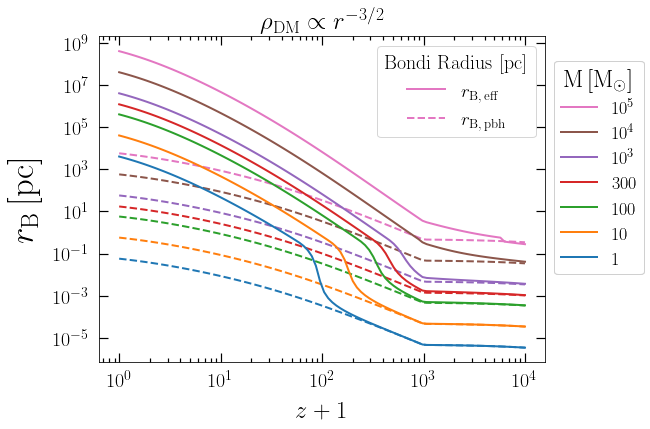

In [12]:
# Calculation of the effective Bondi Radius due to the presence of DM halo
# around the PBH

colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (8, 6))
plt.rc('lines', linewidth = 2)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_arr = np.geomspace(1, 1e4, 100)


r_B_pbh_arr = np.zeros(len(z_arr))
r_B_eff_arr = np.zeros(len(z_arr))




for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for j, z in enumerate(z_arr):
        r_B_pbh_arr[j] = r_B_pbh(z, m)
        r_B_eff_arr[j] = r_B_eff(z, m)
    ax.loglog(z_arr, r_B_eff_arr, color = color)
    ax.loglog(z_arr, r_B_pbh_arr, color = color, ls = '--')
    

    

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], ["$r_\mathrm{B, \,eff}$","$r_\mathrm{B, \,pbh}$"], title = 'Bondi Radius $ \mathrm{[pc]}$',
        title_fontsize = 20, loc = 'upper right', prop = {"size":19})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 24, loc = (1.02, 0.27), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)


plt.xlabel('$z+1$', fontsize = 24.5, labelpad = 10)
plt.ylabel(r"$r_\mathrm{B}\, \mathrm{[pc]}$ ", fontsize = 35, labelpad = 11)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)


plt.title(r'$\rho_\mathrm{DM} \propto r^{-3/2}$', fontsize = 25, pad = 8)
plt.savefig('r_B_eff_BHL.pdf', bbox_inches = 'tight')
plt.show()

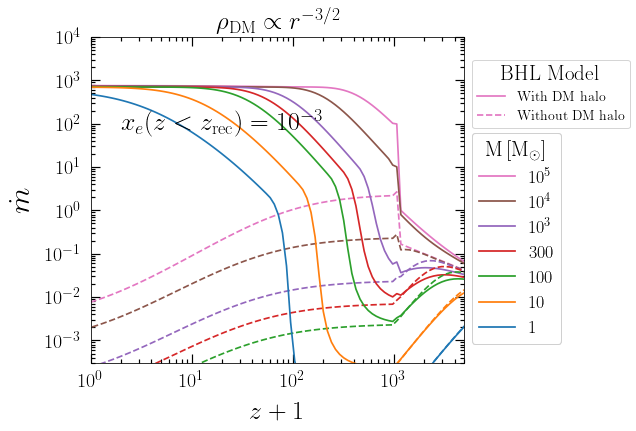

In [13]:
# Plots of m_dot in BHL model with and without the presence of
# DM halos for x_e = 1e-3.

colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')



mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_array = np.geomspace(1e4, 1, 100)
m_dot_pbh_arr = np.zeros(len(z_array))
m_dot_halo_arr = np.zeros(len(z_array))



e_fraction = 1e-3

for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        m_dot_pbh_arr[i] = m_dot_pbh_BHL(z, m)
        m_dot_halo_arr[i] = m_dot_halo_BHL(z, m)
    ax.loglog(z_array, m_dot_halo_arr, color = color)
    ax.loglog(z_array, m_dot_pbh_arr, color = color, ls = '--')
    

plt.text(2, 70, '$x_{e}(z < z_\mathrm{rec}) = 10^{-3}$', fontsize = 26)
plt.xlabel('$z+1$',  fontsize = 26, labelpad = 10)
plt.ylabel(' $\dot m $', fontsize = 31, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [ "With DM halo", "Without DM halo"], title = 'BHL Model',
        title_fontsize = 21, loc = (1.02, 0.72), prop = {"size":14})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 21, loc = (1.02, 0.06), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)



plt.ylim(3e-4, 1e4)
plt.xlim(1, 5000)
plt.title(r'$\rho_\mathrm{DM} \propto r^{-3/2}$', fontsize = 25, pad = 8)
plt.savefig('m_dot_BHL_xe1e-3.pdf', bbox_inches = 'tight')
plt.show()


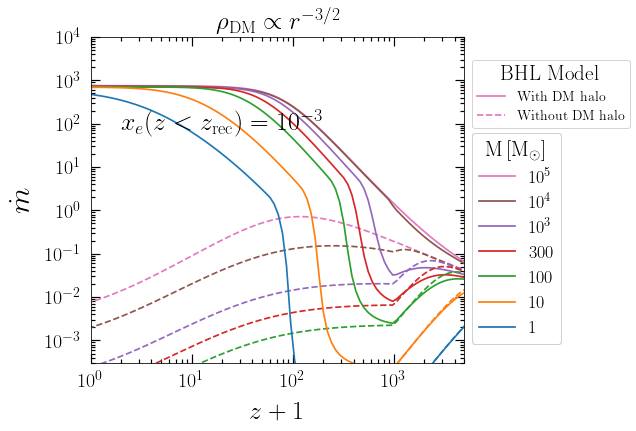

In [14]:
# Plots of m_dot in BHL model with and without the presence of
# DM halos for x_e = 1.

colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')



mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_array = np.geomspace(1e4, 1, 100)
m_dot_pbh_arr = np.zeros(len(z_array))
m_dot_halo_arr = np.zeros(len(z_array))

e_fraction = 1

for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        m_dot_pbh_arr[i] = m_dot_pbh_BHL(z, m)
        m_dot_halo_arr[i] = m_dot_halo_BHL(z, m)
    ax.loglog(z_array, m_dot_halo_arr, color = color)
    ax.loglog(z_array, m_dot_pbh_arr, color = color, ls = '--')
       

plt.text(2, 70, '$x_{e}(z < z_\mathrm{rec}) = 10^{-3}$', fontsize = 26)
plt.xlabel('$z+1$',  fontsize = 26, labelpad = 10)
plt.ylabel(' $\dot m $', fontsize = 31, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [ "With DM halo", "Without DM halo"], title = 'BHL Model',
        title_fontsize = 21, loc = (1.02, 0.72), prop = {"size":14})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 21, loc = (1.02, 0.06), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)



plt.ylim(3e-4, 1e4)
plt.xlim(1, 5000)
plt.title(r'$\rho_\mathrm{DM} \propto r^{-3/2}$', fontsize = 25, pad = 8)
plt.savefig('m_dot_BHL_xe1.pdf', bbox_inches = 'tight')
plt.show()

/tmp/ipykernel_13653/489790489.py:133: RuntimeWarning: overflow encountered in square
  return 4 * np.pi * λ_halo(z, m) * ρ(z) * v_eff(z) * (r_B_eff(z, m)**(2))
/home/pratibhajangra/Desktop/ Project 2/4. Final Calculations/4. DM32/PRaccretion.py:315: RuntimeWarning: invalid value encountered in true_divide
  return ((r_ta_Kavanagh(z, m)/r_ta_Kavanagh(z_eq, m))**(3/2)) * m


RuntimeError: Failed to converge after 50 iterations, value is [nan].

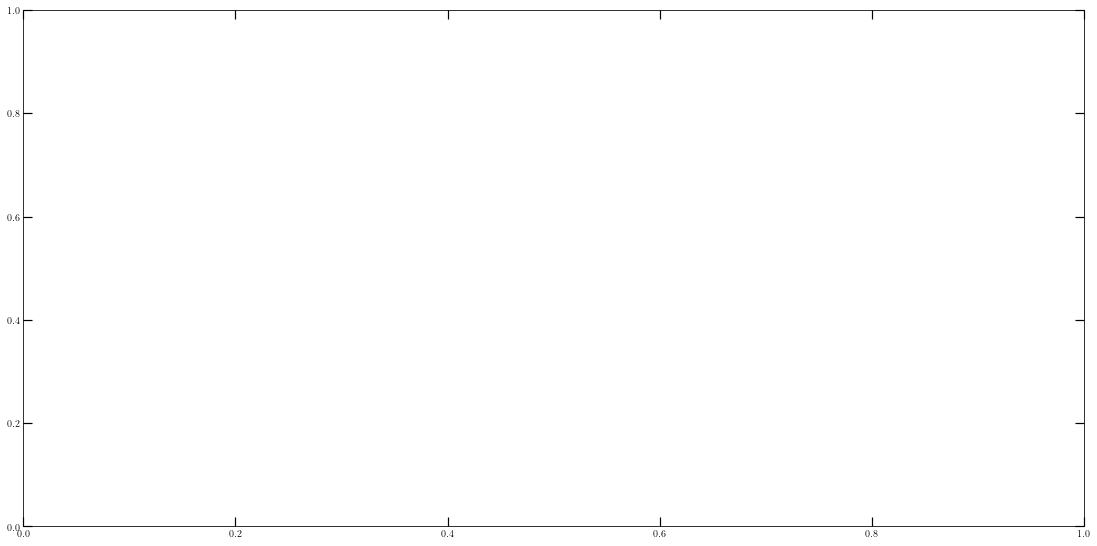

In [15]:
# M_f vs M_i in BHL Model for PBHs with and without DM halos for x_e = 1e-3.


colors = ['C8', 'C9',  'C10']
fig,ax = plt.subplots(1, figsize = (19, 9.5))
plt.rc('lines', linewidth = 2.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


mi_arr = np.geomspace(1, 500, 10)
mf_arr_pbh_BHL = np.zeros(len(mi_arr))
mf_arr_halo_BHL = np.zeros(len(mi_arr))




N = 10
e_fraction = 1e-3 


z_cut_arr = np.array([7, 10, 15])
for i, (z_cut, color) in enumerate(zip(z_cut_arr, colors)):
    for j, m in enumerate(mi_arr):
        f_Hor = 0.2
        z_1i = z_pbh_Ricotti(m, f_Hor)
        y_1i = m
        z_cut_off1 = z_eq
        t1 = np.geomspace(z_1i, z_cut_off1, N)
        sol1_BHL = solve_ivp(M_dot_pbh_BHL_by_dz, t_span = [t1[0], t1[-1]], y0 = [y_1i],  method = 'DOP853',  t_eval = t1)
        sol1_BHL_halo = solve_ivp(M_dot_halo_BHL_by_dz, t_span = [t1[0], t1[-1]], y0 = [y_1i],  method = 'DOP853',  t_eval = t1)
        t1 = sol1_BHL.t
        y1_BHL = sol1_BHL.y[0]
        y1_BHL_halo = sol1_BHL_halo.y[0]
        

        
        z_2i = z_cut_off1
        y_2i_BHL = y1_BHL[-1]
        y_2i_BHL_halo = y1_BHL_halo[-1]
        z_cut_off2 = z_rec
        t2 = np.geomspace(z_2i, z_cut_off2, N)
        sol2_BHL = solve_ivp(M_dot_pbh_BHL_by_dz, t_span = [t2[0], t2[-1]], y0 = [y_2i_BHL], method = 'DOP853', t_eval = t2, first_step = 10, max_step = 100)
        sol2_BHL_halo = solve_ivp(M_dot_halo_BHL_by_dz, t_span = [t2[0], t2[-1]], y0 = [y_2i_BHL_halo], method = 'DOP853', t_eval = t2, first_step = 10, max_step = 100)
        t2 = sol2_BHL.t
        y2_BHL = sol2_BHL.y[0]
        y2_BHL_halo = sol2_BHL_halo.y[0]
        



        z_3i = z_cut_off2
        y_3i_BHL = y2_BHL[-1]
        y_3i_BHL_halo = y2_BHL_halo[-1]
        z_cut_off3 = z_dec
        t3 = np.geomspace(z_3i, z_cut_off3, N)
        sol3_BHL = solve_ivp(M_dot_pbh_BHL_by_dz, t_span = [t3[0], t3[-1]], y0 = [y_3i_BHL], method = 'DOP853', t_eval = t3, first_step = 5, max_step = 10)
        sol3_BHL_halo = solve_ivp(M_dot_halo_BHL_by_dz, t_span = [t3[0], t3[-1]], y0 = [y_3i_BHL_halo], method = 'DOP853', t_eval = t3, first_step = 5, max_step = 10)
        t3 = sol3_BHL.t
        y3_BHL = sol3_BHL.y[0]
        y3_BHL_halo = sol3_BHL_halo.y[0]
       

        
        
        z_4i = z_cut_off3
        y_4i_BHL = y3_BHL[-1]
        y_4i_BHL_halo = y3_BHL_halo[-1]
        z_cut_off4 = z_cut
        t4 = np.geomspace(z_4i, z_cut_off4, N)
        sol4_BHL = solve_ivp(M_dot_pbh_BHL_by_dz, t_span = [t4[0], t4[-1]], y0 = [y_4i_BHL], method = 'DOP853', t_eval = t4, first_step = 5, max_step = 10)
        sol4_BHL_halo = solve_ivp(M_dot_halo_BHL_by_dz, t_span = [t4[0], t4[-1]], y0 = [y_4i_BHL_halo], method = 'DOP853', t_eval = t4, first_step = 5, max_step = 10)
        t4 = sol4_BHL.t
        y4_BHL = sol4_BHL.y[0]
        y4_BHL_halo = sol4_BHL_halo.y[0]
       
        
        
        mf_arr_pbh_BHL[j] = y4_BHL[-1]
        mf_arr_halo_BHL[j] = y4_BHL_halo[-1]
        
    
    ax.loglog(mi_arr, np.divide(mf_arr_halo_BHL, mi_arr), color = color)
    ax.loglog(mi_arr, np.divide(mf_arr_pbh_BHL, mi_arr), color = color, ls = ':')
        
    
    
    
    
ax.tick_params(axis ='x', pad = 9.9)
ax.tick_params(axis ='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], ["With DM halo", "Without DM halos "], title = 'BHL Accretion Model',
        title_fontsize = 37, loc = 'upper left', prop = {"size":29})
legend2 = plt.legend([lines[i] for i in [0, 2, 4]], ['$7$', r'$10$', 
           r'$15$'], title = '$z_\mathrm{cut-off} $',
           title_fontsize = 37, loc = (0.03, 0.27), prop = {"size":35})
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.tick_params(axis = 'y', which = 'minor', labelsize = 26)

plt.xlim(1, 300)
plt.ylim(0.9, 100)
plt.xticks(fontsize = 38)
plt.yticks(fontsize = 38)
plt.xlabel('$\mathrm{M}_{i}$',fontsize = 47, labelpad = 20)
plt.ylabel(r'$\mathrm{M}_{f}(z < z_\mathrm{cut-off})/\mathrm{M}_{i} $',fontsize = 50, labelpad = 16)
plt.xscale('log')
plt.title(r'$\rho_\mathrm{DM} \propto r^{-9/4},\,  x_{e}(z < z_\mathrm{rec}) = 10^{-3}$', fontsize = 36, pad = 11)
#plt.savefig('Mf_xe1e-3_BHL.pdf', bbox_inches = 'tight')
plt.show()